# Example Pipeline for Lalonde

This notebook is a proof-of-concept for generating causal samples from external samples

In [1]:
import contextlib
import sys
import os
sys.path.append("../")  # go to parent dir
# sys.path.append("../data/analysis/")  # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
# jnp.set_printoptions(precision=2)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import rankdata

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow
from frugal_flows.sample_outcome import sample_outcome
from frugal_flows.sample_marginals import from_quantiles_to_marginal_cont, from_quantiles_to_marginal_discr
from frugal_flows.train_quantile_propensity_score import train_quantile_propensity_score
from frugal_flows.bijections import UnivariateNormalCDF
from frugal_flows.benchmarking import FrugalFlowModel
from frugal_flows.sample_outcome import sample_outcome
from frugal_flows.sample_marginals import from_quantiles_to_marginal_cont, from_quantiles_to_marginal_discr
from frugal_flows.train_quantile_propensity_score import train_quantile_propensity_score


import data.template_causl_simulations as causl_py
import data.analysis.validationMethods as valMethods
import wandb

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()
base = importr('base')
utils = importr('utils')

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))

seed = 0
N = 2000
B = 50
sampling_size = 1000
keys, *subkeys = jr.split(jr.PRNGKey(seed), 20)

def clean_ate(value):
    if isinstance(value, (list, tuple, np.ndarray)):
        return np.mean(value)
    return value

In [2]:
hyperparam_dict = {
    'learning_rate': 0.00261635,
    'RQS_knots': 5,
    'flow_layers': 2,
    'nn_depth': 3,    
    'nn_width': 34,
    'max_patience': 200,
    'max_epochs': 20000
}
causal_margin_hyperparams_dict = {
    'RQS_knots': 4,
    'flow_layers': 8,
    'nn_depth': 10,    
    'nn_width': 50,
}
seed=7
causal_params = [1,1]
B = 5

# Load data
e401k = pd.read_csv('../data/filtered_401k_data.csv')

# Preprocess data
outcome_col = 'net_tfa'
treatment_col = 'e401'
standardised_outcome_col = f'{outcome_col}_standardised'
Y_control = e401k.loc[e401k[treatment_col]==0, outcome_col]
Y_control_mean = Y_control.mean()
Y_control_std = Y_control.std()
e401k[standardised_outcome_col] = (e401k[outcome_col] - Y_control_mean) / Y_control_std
e401k_filtered = e401k.loc[(e401k[standardised_outcome_col] > -2) & (e401k[standardised_outcome_col] < +3)]
X = jnp.array(e401k_filtered[treatment_col].values)[:, None]
Y = jnp.array(e401k_filtered[standardised_outcome_col].values)[:, None]
Z_disc = jnp.array(e401k_filtered[[col for col in e401k_filtered.columns if col not in [outcome_col,standardised_outcome_col, treatment_col]]].values)


true_ATE = 1000
benchmark_flow = FrugalFlowModel(Y=Y, X=X, Z_disc=Z_disc, Z_cont=None, confounding_copula=None)
benchmark_flow.train_benchmark_model(
    training_seed=jr.PRNGKey(seed),
    marginal_hyperparam_dict=hyperparam_dict,
    frugal_hyperparam_dict=hyperparam_dict,
    causal_model='location_translation',
    causal_model_args={'ate': 0, **causal_margin_hyperparams_dict},
    prop_flow_hyperparam_dict=hyperparam_dict
)

  1%|█                                                                                                   | 202/20000 [00:24<39:54,  8.27it/s, train=6.641565261596405, val=6.586239900629962 (Max patience reached)]


In [3]:
def rescale_outcome(x, mean, std):
    return x * std + mean

### Unconfounded Data

In [4]:
non_confounded_results_list = []
for seed in range(B):
    print(f"Run {seed+1} / {B}")
    sim_data_df = benchmark_flow.generate_samples(
        key=jr.PRNGKey(10*seed),
        sampling_size=sampling_size,
        copula_param=0.,
        outcome_causal_model='location_translation',
        outcome_causal_args={'ate': true_ATE / Y_control_std},
        with_confounding=False
    )
    sim_data_df['Y'] = sim_data_df['Y'].apply(lambda x: rescale_outcome(x, Y_control_mean, Y_control_std))
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        model_fits = valMethods.run_model_fits('Y', 'X', sim_data_df, sample_frac=1, repeats=1, replace=True)
    ate_reslts = pd.concat([
        model_fits['nonbootstrap_results'][['method', 'ate']], 
        model_fits['bootstrap_results'][['method', 'ate']]
    ])
    non_confounded_results_list.append(ate_reslts)
non_confounded_model_fit_results = pd.concat(non_confounded_results_list)
non_confounded_model_fit_results = non_confounded_model_fit_results.loc[
    ~non_confounded_model_fit_results['method'].isin(['Gradient Boosting Trees DML', 'Doubly Robust (Linear)'])
]
non_confounded_model_fit_results['ate'] = non_confounded_model_fit_results['ate'].apply(clean_ate)

Run 1 / 5
(1000, 10)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed 

Run 2 / 5
(1000, 10)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed 

Run 3 / 5
(1000, 10)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed 

Run 4 / 5
(1000, 10)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed 

Run 5 / 5
(1000, 10)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed 

### Confounded Data

In [5]:
confounded_results_list = []
for seed in range(B):
    print(f"Run {seed+1} / {B}")
    sim_data_df = benchmark_flow.generate_samples(
        key=jr.PRNGKey(10*seed),
        sampling_size=sampling_size,
        copula_param=0.,
        outcome_causal_model='location_translation',
        outcome_causal_args={'ate': true_ATE / Y_control_std},
        with_confounding=True
    )
    sim_data_df['Y'] = sim_data_df['Y'].apply(lambda x: rescale_outcome(x, Y_control_mean, Y_control_std))    
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        model_fits = valMethods.run_model_fits('Y', 'X', sim_data_df, sample_frac=1, repeats=1, replace=True)
    ate_reslts = pd.concat([
        model_fits['nonbootstrap_results'][['method', 'ate']], 
        model_fits['bootstrap_results'][['method', 'ate']]
    ])
    confounded_results_list.append(ate_reslts)
confounded_model_fit_results = pd.concat(confounded_results_list)
confounded_model_fit_results = confounded_model_fit_results.loc[
    ~confounded_model_fit_results['method'].isin(['Gradient Boosting Trees DML', 'Doubly Robust (Linear)'])
]
confounded_model_fit_results['ate'] = confounded_model_fit_results['ate'].apply(clean_ate)

Run 1 / 5
(1000, 10)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed 

Run 2 / 5
(1000, 10)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed 

Run 3 / 5
(1000, 10)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed 

Run 4 / 5
(1000, 10)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed 

Run 5 / 5
(1000, 10)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed 

### Hidden Confounded Data

In [6]:
hidden_confounded_results_list = []
for seed in range(B):
    print(f"Run {seed+1} / {B}")
    sim_data_df = benchmark_flow.generate_samples(
        key=jr.PRNGKey(10*seed),
        sampling_size=sampling_size,
        copula_param=0.5,
        outcome_causal_model='location_translation',
        outcome_causal_args={'ate': true_ATE / Y_control_std},
        with_confounding=True
    )
    sim_data_df['Y'] = sim_data_df['Y'].apply(lambda x: rescale_outcome(x, Y_control_mean, Y_control_std))    
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        model_fits = valMethods.run_model_fits('Y', 'X', sim_data_df, sample_frac=1, repeats=1, replace=True)
    ate_reslts = pd.concat([
        model_fits['nonbootstrap_results'][['method', 'ate']], 
        model_fits['bootstrap_results'][['method', 'ate']]
    ])
    hidden_confounded_results_list.append(ate_reslts)
hidden_confounded_model_fit_results = pd.concat(hidden_confounded_results_list)
hidden_confounded_model_fit_results = hidden_confounded_model_fit_results.loc[
    ~hidden_confounded_model_fit_results['method'].isin(['Gradient Boosting Trees DML', 'Doubly Robust (Linear)'])
]
hidden_confounded_model_fit_results['ate'] = hidden_confounded_model_fit_results['ate'].apply(clean_ate)

Run 1 / 5
(1000, 10)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed 

Run 2 / 5
(1000, 10)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed 

Run 3 / 5
(1000, 10)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed 

Run 4 / 5
(1000, 10)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed 

Run 5 / 5
(1000, 10)


Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed 

## Some demo plots

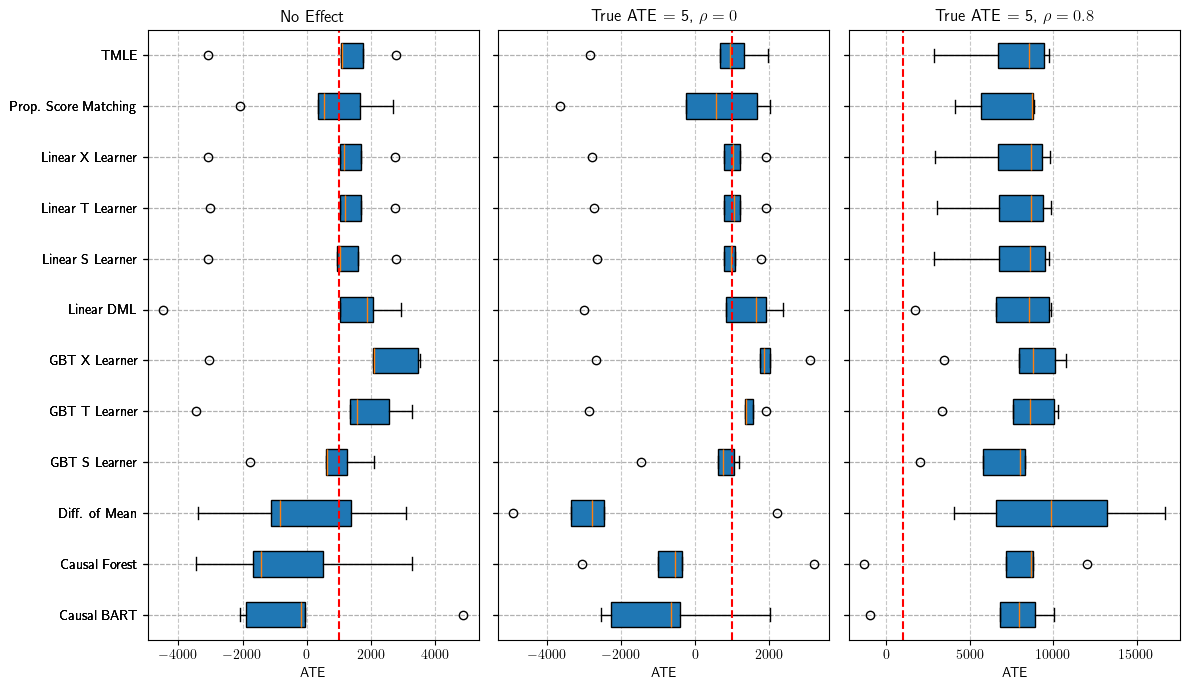

In [7]:
plt.rcParams['text.usetex'] = True

def clean_ate(value):
    if isinstance(value, (list, tuple, np.ndarray)):
        return np.mean(value)
    return value

df1 = non_confounded_model_fit_results.copy()
df2 = confounded_model_fit_results.copy()
df3 = hidden_confounded_model_fit_results.copy()

# Group data by method
grouped_df1 = df1.groupby('method')['ate'].apply(list).reset_index()
grouped_df2 = df2.groupby('method')['ate'].apply(list).reset_index()
grouped_df3 = df3.groupby('method')['ate'].apply(list).reset_index()

# Plot the box and whisker diagrams side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 7), sharey=True)

# Create the boxplot for the first dataset
axes[0].boxplot(grouped_df1['ate'], vert=False, patch_artist=True, labels=grouped_df1['method'])
axes[0].axvline(x=true_ATE, color='red', linestyle='--')
axes[0].set_xlabel('ATE')
axes[0].set_title('No Effect')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Create the boxplot for the second dataset
axes[1].boxplot(grouped_df2['ate'], vert=False, patch_artist=True, labels=grouped_df2['method'])
axes[1].axvline(x=true_ATE, color='red', linestyle='--')
axes[1].set_xlabel('ATE')
axes[1].set_title(r'True ATE = 5, $\rho=0$')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Create the boxplot for the second dataset
axes[2].boxplot(grouped_df3['ate'], vert=False, patch_artist=True, labels=grouped_df3['method'])
axes[2].axvline(x=true_ATE, color='red', linestyle='--')
axes[2].set_xlabel('ATE')
axes[2].set_title(r'True ATE = 5,  $\rho=0.8$')
axes[2].grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

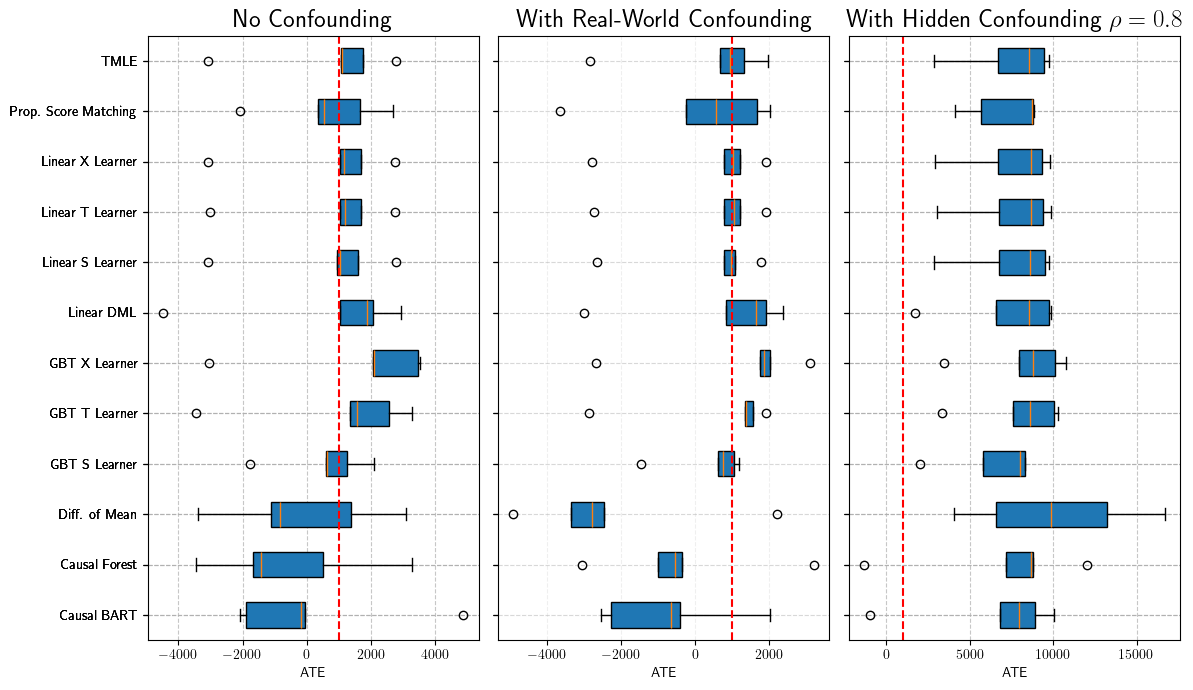

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['text.usetex'] = True

def clean_ate(value):
    if isinstance(value, (list, tuple, np.ndarray)):
        return np.mean(value)
    return value

df1 = non_confounded_model_fit_results.copy()
df2 = confounded_model_fit_results.copy()
df3 = hidden_confounded_model_fit_results.copy()

# Group data by method
grouped_df1 = df1.groupby('method')['ate'].apply(list).reset_index()
grouped_df2 = df2.groupby('method')['ate'].apply(list).reset_index()
grouped_df3 = df3.groupby('method')['ate'].apply(list).reset_index()

# Plot the box and whisker diagrams side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 7), sharey=True)

# Define a common font size
font_size = 16
title_fontsize = font_size + 2

# Create the boxplot for the first dataset
axes[0].boxplot(grouped_df1['ate'], vert=False, patch_artist=True, labels=grouped_df1['method'])
axes[0].axvline(x=true_ATE, color='red', linestyle='--')
axes[0].set_xlabel('ATE')
axes[0].set_title('No Confounding', fontsize=title_fontsize)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Create the boxplot for the second dataset
axes[1].boxplot(grouped_df2['ate'], vert=False, patch_artist=True, labels=grouped_df2['method'])
axes[1].axvline(x=true_ATE, color='red', linestyle='--')
axes[1].set_xlabel('ATE')
axes[1].set_title(r'With Real-World Confounding', fontsize=title_fontsize)
axes[1].grid(True, linestyle='--', alpha=0.2)

# Create the boxplot for the third dataset
axes[2].boxplot(grouped_df3['ate'], vert=False, patch_artist=True, labels=grouped_df3['method'])
axes[2].axvline(x=true_ATE, color='red', linestyle='--')
axes[2].set_xlabel('ATE')
axes[2].set_title(r'With Hidden Confounding $\rho=0.8$', fontsize=title_fontsize)
axes[2].grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('simulated_box_and_whisker_plots.pdf', format='pdf')

# Display the plot
plt.show()


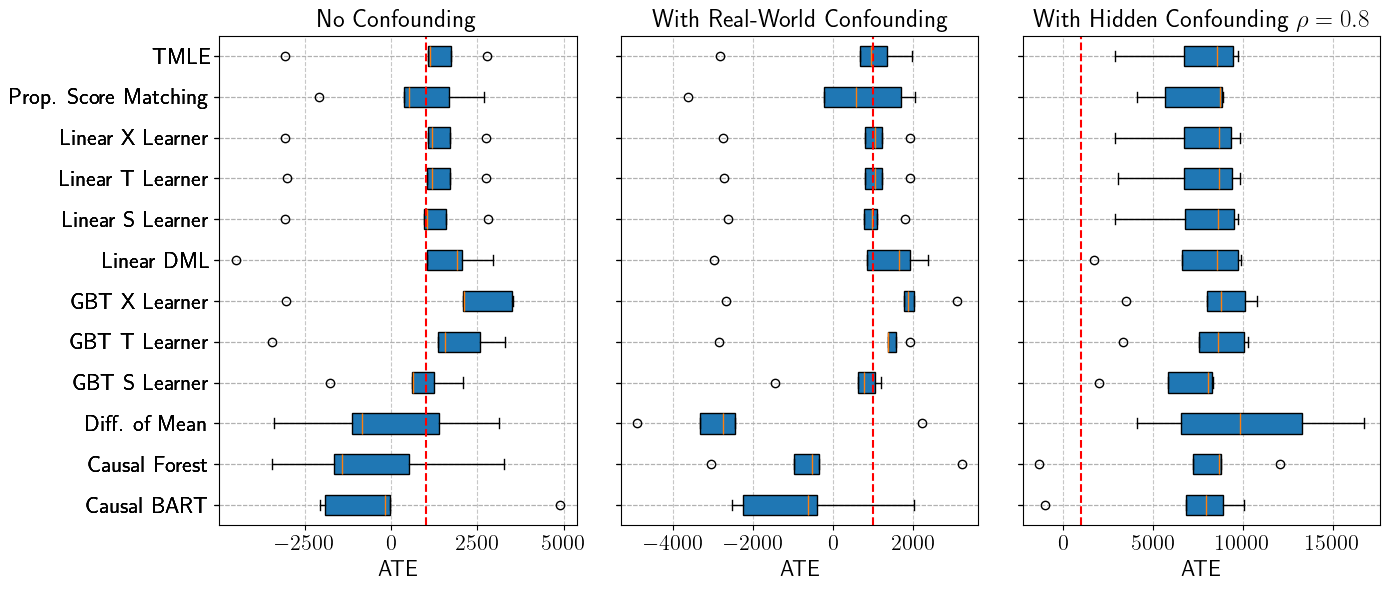

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['text.usetex'] = True

def clean_ate(value):
    if isinstance(value, (list, tuple, np.ndarray)):
        return np.mean(value)
    return value

# Apply the cleaning function to the data
df1 = non_confounded_model_fit_results.copy()
df2 = confounded_model_fit_results.copy()
df3 = hidden_confounded_model_fit_results.copy()

# Group data by method
grouped_df1 = df1.groupby('method')['ate'].apply(list).reset_index()
grouped_df2 = df2.groupby('method')['ate'].apply(list).reset_index()
grouped_df3 = df3.groupby('method')['ate'].apply(list).reset_index()

# Plot the box and whisker diagrams side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6), sharey=True)

# Define a common font size
font_size = 16
title_fontsize = font_size + 2

# Create the boxplot for the first dataset
axes[0].boxplot(grouped_df1['ate'], vert=False, patch_artist=True, labels=grouped_df1['method'])
axes[0].axvline(x=true_ATE, color='red', linestyle='--')
axes[0].set_xlabel('ATE', fontsize=font_size)
axes[0].set_title('No Confounding', fontsize=title_fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=font_size)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Create the boxplot for the second dataset
axes[1].boxplot(grouped_df2['ate'], vert=False, patch_artist=True, labels=grouped_df2['method'])
axes[1].axvline(x=true_ATE, color='red', linestyle='--')
axes[1].set_xlabel('ATE', fontsize=font_size)
axes[1].set_title(r'With Real-World Confounding', fontsize=title_fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=font_size)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Create the boxplot for the third dataset
axes[2].boxplot(grouped_df3['ate'], vert=False, patch_artist=True, labels=grouped_df3['method'])
axes[2].axvline(x=true_ATE, color='red', linestyle='--')
axes[2].set_xlabel('ATE', fontsize=font_size)
axes[2].set_title(r'With Hidden Confounding $\rho=0.8$', fontsize=title_fontsize)
axes[2].tick_params(axis='both', which='major', labelsize=font_size)
axes[2].grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('e401k_box_and_whisker_plots.pdf', format='pdf')

# Display the plot
plt.show()